In this lab, you will implement the locally linear embedding algorithm.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker
import mpl_toolkits.mplot3d
from numpy.linalg import eigh, inv
from sklearn.neighbors import kneighbors_graph

from sklearn import manifold, datasets

# We will use data sampled from the swiss roll manifold
n_samples = 2000
S_points, S_color = datasets.make_swiss_roll(n_samples, random_state=0)

In [2]:
# These are for visualization
def plot_3d(points, points_color, title):
    x, y, z = points.T

    fig, ax = plt.subplots(
        figsize=(7, 7),
        facecolor="white",
        tight_layout=True,
        subplot_kw={"projection": "3d"},
    )
    fig.suptitle(title, size=16)
    col = ax.scatter(x, y, z, c=points_color, s=50, alpha=0.8)
    ax.view_init(azim=-60, elev=9)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.zaxis.set_major_locator(ticker.MultipleLocator(1))

    fig.colorbar(col, ax=ax, orientation="horizontal", shrink=0.6, aspect=60, pad=0.01)
    plt.show()


def plot_2d(points, points_color, title, figsize=(3, 3)):
    fig, ax = plt.subplots(figsize=figsize, facecolor="white", constrained_layout=True)
    fig.suptitle(title, size=16)
    add_2d_scatter(ax, points, points_color)
    plt.show()


def add_2d_scatter(ax, points, points_color, title=None):
    x, y = points.T
    ax.scatter(x, y, c=points_color, s=50, alpha=0.8)
    ax.set_title(title)
    ax.xaxis.set_major_formatter(ticker.NullFormatter())
    ax.yaxis.set_major_formatter(ticker.NullFormatter())

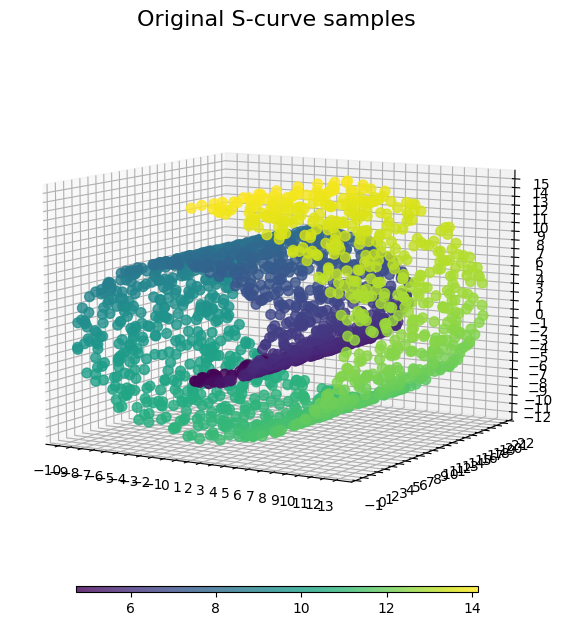

In [3]:
# Plot the data
plot_3d(S_points, S_color, "Original S-curve samples")

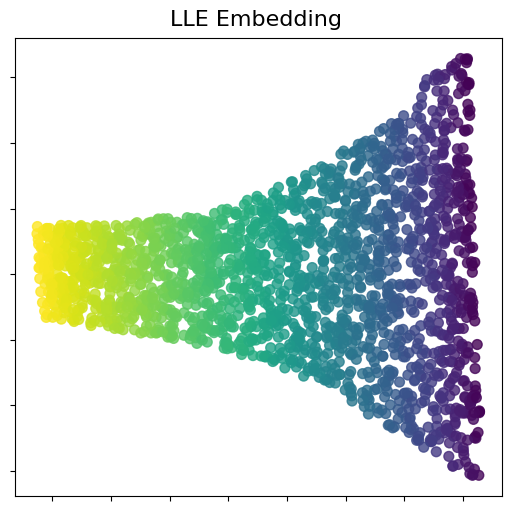

In [4]:
n_neighbors = 20  # number of neighbors for generating a graph
n_components = 2  # number of coordinates for the manifold

lle = manifold.LocallyLinearEmbedding(n_neighbors=n_neighbors, n_components=n_components)
S_lle = lle.fit_transform(S_points)

# This plot generates a bit different version (in terms of the regularizer) 
# of your own LLE representation
plot_2d(S_lle, S_color, "LLE Embedding", figsize=(5,5))

In [5]:
"""TODO: implement the following function."""
def compute_weights(data, k, alpha):
# Here, you will computes a weight matrix W used for approximating each data
# point as a linear combination of its neighbors

# You can freely implement "subfunctions" that helps implementing this function

# The below indicates input/output of the compute_weights function.
# Input
# data: a data matrix of size n x p
# k: number of neighbors used for constructing a neighbor graph
# alpha: the regularization parameter used for avoiding degenerate solutions
#        (see page 26 of Lec4)
# Output
# W: a matrix of size n x n
#    - its (i,j)-th entry zero if j is not a k-nearest neighbor of i 
#    - its (i,j)-th entry is w_ij otherwise
#      (w_ij is a solution of the minimization problem in page 20 of Lec4)

    n, p = data.shape
    D = kneighbors_graph(data, n_neighbors=k, mode="connectivity").toarray()
    neighbors = D.nonzero()[1].reshape(n, k)
    
    data = data - np.mean(data, axis=0)
    W = np.zeros((n, n))
    for i in range(n):
        Z = data[neighbors[i]] - data[i]
        C = np.dot(Z, Z.T)
        C += np.eye(k) * alpha # Add regularization to improve stability
        w = inv(C).sum(axis=1)
        w /= np.sum(w)
        W[i, neighbors[i]] = w
    
    return W

In [6]:
def compute_embedding(W, n_components):
# Here, you will computes an low-dimensional representation U preserving the
# "local information" given by the LLE objective (see pages 20, 28 of Lec4)

# You can freely implement "subfunctions" that helps implementing this function

# The below indicates input/output of the compute_weights function.
# Input
# W: the weight matrix given by "compute_weights" function
# n_components: the dimentionality of the target low-dimensional space
# Output
# U: a matrix of size (n_components x n)
#    - the i-th column of U should be the representation of the i-th data

  # Step 4: Compute the low-dimensional embedding
  n, n = W.shape
  M = np.eye(n) - W
  eigenvalues, eigenvectors = np.linalg.eigh(np.dot(M.T, M))
  sorted_indices = np.argsort(eigenvalues)[1:]
  U = eigenvectors[:, sorted_indices][:, :n_components].T
  return U

In [7]:
W = compute_weights(S_points, n_neighbors, 0.01)
U = compute_embedding(W, n_components)

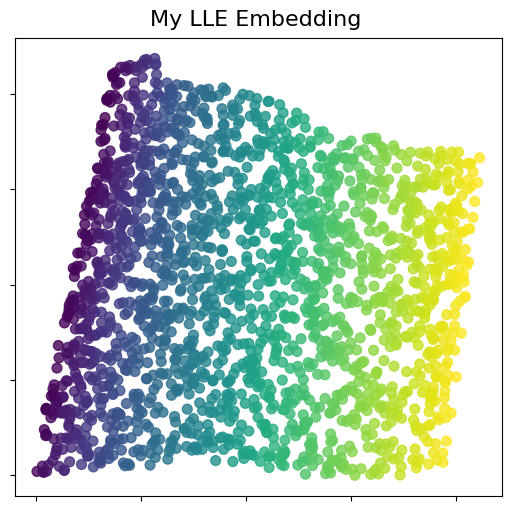

In [8]:
plot_2d(U.transpose(), S_color, "My LLE Embedding", figsize=(5,5))